CELL 1: SETUP & DATA LOADING

In [1]:
# --- CELL 1: SETUP & DATA PREPARATION ---
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
import warnings

warnings.filterwarnings("ignore")
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

# 1. Cargar Datos (Features Engineering Output)
filename = 'train_256063_features_lean.csv'
print(f"Loading dataset: {filename}...")

try:
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    
    # A) Preparar datos para XGBoost (Sin NaNs)
    target_col = 'demand'
    feature_cols = [c for c in df.columns if c != target_col]
    df_ml = df.dropna()
    
    X = df_ml[feature_cols]
    y = df_ml[target_col]
    
    # B) Preparar datos para SARIMA (Serie continua)
    # Rellenamos huecos iniciales para que no falle al arrancar
    y_sarima = df[target_col].asfreq('h').ffill().bfill()
    
    print(f"Data Ready.")
    print(f"   - XGBoost Samples: {len(X)} (Features: {len(feature_cols)})")
    print(f"   - SARIMA Series Length: {len(y_sarima)}")
    
except FileNotFoundError:
    print("Error: File not found. Please run Task 5 first.")

# Función de Error NRMSE
def calculate_nrmse(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    range_y = y_true.max() - y_true.min()
    return rmse / range_y if range_y != 0 else 0

Loading dataset: train_256063_features_lean.csv...
Data Ready.
   - XGBoost Samples: 8736 (Features: 28)
   - SARIMA Series Length: 8736


CELL 2: HYPERPARAMETER TUNING (XGBoost)

In [2]:
# --- CELL 2: HYPERPARAMETER OPTIMIZATION (XGBoost) ---
print("\n--- 8.2. Hyperparameter Tuning (XGBoost) ---")

# 1. Separamos la última semana (Test) para no usarla en la optimización
test_days = 7
test_hours = test_days * 24
X_train_opt = X.iloc[:-test_hours]
y_train_opt = y.iloc[:-test_hours]

# 2. Rejilla de parámetros a probar
param_grid = {
    'n_estimators': [300, 500, 700],
    'max_depth': [3, 5, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8]
}

# 3. Búsqueda Aleatoria (Random Search)
tscv = TimeSeriesSplit(n_splits=3)
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

print("Running Randomized Search (Finding best AI configuration)...")
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=15, # Probará 15 combinaciones
    scoring='neg_root_mean_squared_error',
    cv=tscv,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train_opt, y_train_opt)
best_xgb_params = random_search.best_params_

print(f"Best XGBoost Params Found: {best_xgb_params}")


--- 8.2. Hyperparameter Tuning (XGBoost) ---
Running Randomized Search (Finding best AI configuration)...
Best XGBoost Params Found: {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}


CELL 3: WALK-FORWARD BATTLE (XGBoost vs SARIMA)

In [3]:
# --- CELL 3: WALK-FORWARD VALIDATION (XGBOOST VS SARIMA) ---
print("\n--- 8.3. The Final Battle: XGBoost vs SARIMA ---")

# CONFIGURACIÓN
# Si no has corrido la Celda 2, usamos valores por defecto
if 'best_xgb_params' not in locals():
    best_xgb_params = {'n_estimators': 500, 'learning_rate': 0.05, 'max_depth': 6}

sarima_order = (1, 0, 1)        # Configuración ganadora de Tarea 7
sarima_seasonal = (0, 1, 1, 24)

steps = 7           
horizon = 24        
total_hours = steps * horizon

# Índices de corte
train_end_idx_xgb = len(X) - total_hours
train_end_idx_sarima = len(y_sarima) - total_hours

preds_xgb = []
preds_sarima = []
actuals = []

print(f"Simulating {steps} days forecast...")

# Pre-entrenamiento inicial de SARIMA (para velocidad con .filter)
history_sarima = y_sarima.iloc[:-total_hours]
model_sarima_init = SARIMAX(history_sarima, order=sarima_order, seasonal_order=sarima_seasonal,
                            enforce_stationarity=False, enforce_invertibility=False)
res_sarima = model_sarima_init.fit(disp=False)

for day in range(steps):
    # --- 1. XGBOOST (Re-entrenamiento diario) ---
    idx = train_end_idx_xgb + (day * horizon)
    X_train, y_train = X.iloc[:idx], y.iloc[:idx]
    X_test, y_test = X.iloc[idx : idx+horizon], y.iloc[idx : idx+horizon]
    
    # Entrenar (Guardamos en 'model_xgb' para ver feature importance luego)
    model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42, **best_xgb_params)
    model_xgb.fit(X_train, y_train)
    
    preds_xgb.extend(model_xgb.predict(X_test))
    actuals.extend(y_test.values)
    
    # --- 2. SARIMA (Actualización rápida) ---
    idx_s = train_end_idx_sarima + (day * horizon)
    current_history = y_sarima.iloc[:idx_s]
    
    mod_s = SARIMAX(current_history, order=sarima_order, seasonal_order=sarima_seasonal,
                    enforce_stationarity=False, enforce_invertibility=False)
    # Usamos parámetros ya aprendidos para ir rápido
    res_s = mod_s.filter(res_sarima.params)
    preds_sarima.extend(res_s.forecast(steps=horizon))
    
    print(f"   -> Day {day+1}/{steps} Completed.")

# CREAR SERIES DE RESULTADOS
index_test = y.index[-total_hours:]
series_xgb = pd.Series(preds_xgb, index=index_test)
series_sarima = pd.Series(preds_sarima, index=index_test)
series_actual = pd.Series(actuals, index=index_test)

# CALCULAR ERRORES
nrmse_xgb = calculate_nrmse(series_actual, series_xgb)
nrmse_sarima = calculate_nrmse(series_actual, series_sarima)

print(f"Cálculos terminados.")


--- 8.3. The Final Battle: XGBoost vs SARIMA ---
Simulating 7 days forecast...
   -> Day 1/7 Completed.
   -> Day 2/7 Completed.
   -> Day 3/7 Completed.
   -> Day 4/7 Completed.
   -> Day 5/7 Completed.
   -> Day 6/7 Completed.
   -> Day 7/7 Completed.
Cálculos terminados.


CELL 4: COMPARISON TABLE & VISUALIZATION


FINAL LEADERBOARD:
               Model                                                                                           Configuration  NRMSE (Walk-Forward)
        XGBoost (ML) {'subsample': 0.7, 'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.01, 'colsample_bytree': 0.8}              0.137420
SARIMA (Statistical)                                                                          Order: (1, 0, 1)x(0, 1, 1, 24)              0.149704
Gráfica de comparación guardada: results/task8\MLvsStatisticalModel.png


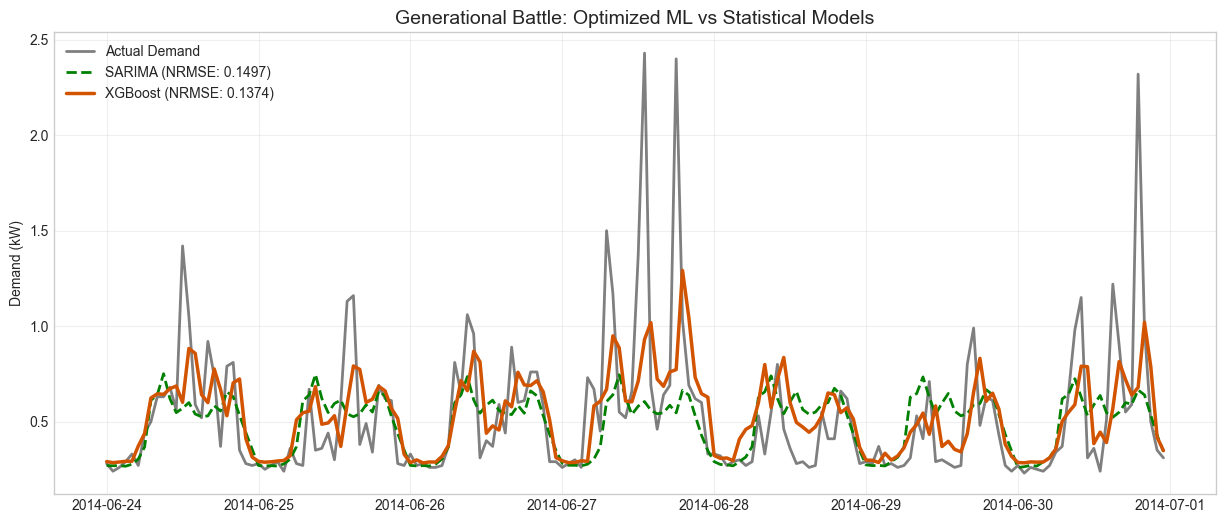

Gráfica de Features guardada: results/task8\topImportantFeatures.png


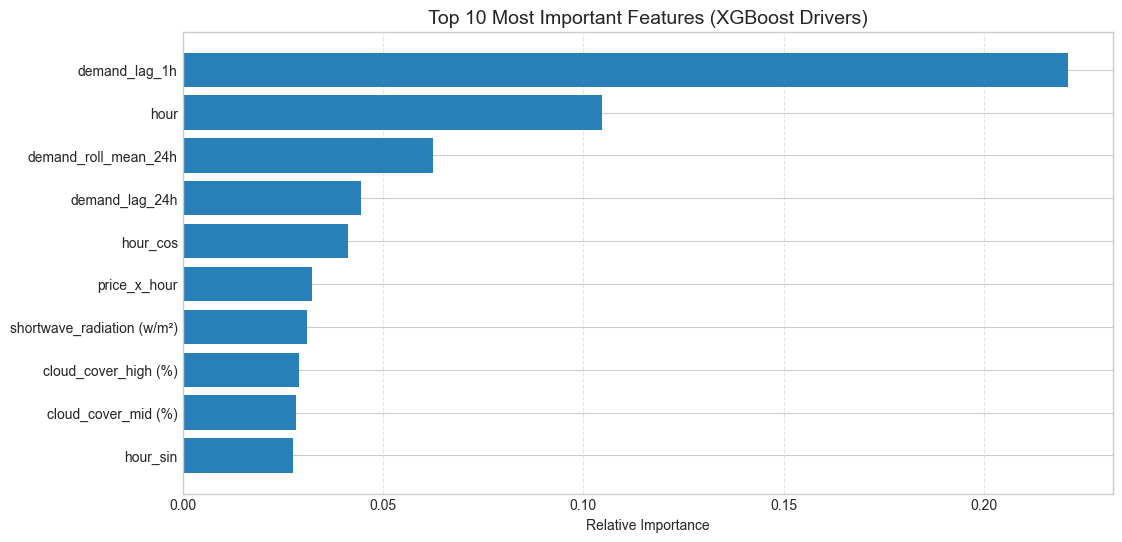


CONCLUSION: XGBoost wins by 8.2%!
   Reason: It combines historical lags with context (Temp, Hour, Day).


In [4]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# --- CELL 4: FINAL RESULTS & COMPARISON ---

# Configuración de guardado
output_dir = 'results/task8'
os.makedirs(output_dir, exist_ok=True)

try:
    # 1. TABLA COMPARATIVA
    comparison_df = pd.DataFrame({
        'Model': ['XGBoost (ML)', 'SARIMA (Statistical)'],
        'Configuration': [str(best_xgb_params), f"Order: {sarima_order}x{sarima_seasonal}"],
        'NRMSE (Walk-Forward)': [nrmse_xgb, nrmse_sarima]
    })

    print("\nFINAL LEADERBOARD:")
    print(comparison_df.to_string(index=False))

    # ==========================================
    # GRÁFICA 1: PREDICCIONES (ML vs Statistical)
    # ==========================================
    plt.figure(figsize=(15, 6))
    
    plt.plot(index_test, series_actual, label='Actual Demand', color='black', alpha=0.5, linewidth=2)
    plt.plot(index_test, series_sarima, label=f'SARIMA (NRMSE: {nrmse_sarima:.4f})', color='green', linestyle='--', linewidth=2)
    plt.plot(index_test, series_xgb, label=f'XGBoost (NRMSE: {nrmse_xgb:.4f})', color='#d35400', linewidth=2.5)
    
    plt.title("Generational Battle: Optimized ML vs Statistical Models", fontsize=14)
    plt.ylabel("Demand (kW)")
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Guardar Gráfica 1
    save_path1 = os.path.join(output_dir, 'MLvsStatisticalModel.png')
    plt.savefig(save_path1, dpi=300, bbox_inches='tight')
    print(f"Gráfica de comparación guardada: {save_path1}")
    
    plt.show()

    # ==========================================
    # GRÁFICA 2: IMPORTANCIA DE VARIABLES
    # ==========================================
    plt.figure(figsize=(12, 6))
    
    sorted_idx = model_xgb.feature_importances_.argsort()
    # Tomamos las top 10
    plt.barh(X.columns[sorted_idx][-10:], model_xgb.feature_importances_[sorted_idx][-10:], color='#2980b9')
    
    plt.title("Top 10 Most Important Features (XGBoost Drivers)", fontsize=14)
    plt.xlabel("Relative Importance")
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Guardar Gráfica 2
    save_path2 = os.path.join(output_dir, 'topImportantFeatures.png')
    plt.savefig(save_path2, dpi=300, bbox_inches='tight')
    print(f"Gráfica de Features guardada: {save_path2}")
    
    plt.show()

    # 3. VEREDICTO
    if nrmse_xgb < nrmse_sarima:
        imp = ((nrmse_sarima - nrmse_xgb) / nrmse_sarima) * 100
        print(f"\nCONCLUSION: XGBoost wins by {imp:.1f}%!")
        print("   Reason: It combines historical lags with context (Temp, Hour, Day).")
    else:
        print("\nCONCLUSION: SARIMA holds its ground (History is powerful).")

except Exception as e:
    print(f"Error al generar los resultados finales: {e}")

CELL 5: REPORT TEXT (Markdown)